In [1]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
from keras.initializers import RandomUniform
import os
import random as rn
from tensorflow import set_random_seed
from keras.callbacks import EarlyStopping
from keras import regularizers
import pickle
from os import path
import tensorflow as tf
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import *
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
def loadGloveModel(gloveFile):
    if path.exists("./embeddings/glove_pickle.pkl"):
        with open('./embeddings/glove_pickle.pkl', 'rb') as f:
            glov = pickle.load(f)
            print('found it')
            return glov
    
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    
    #glov = loadGloveModel('./embeddings/glove_german_vec.txt')
    with open('./embeddings/glove_pickle.pkl', "wb") as f:
        pickle.dump(model, f)
    return model

In [4]:
glov = loadGloveModel('./embeddings/glove_german_vec.txt')

Loading Glove Model


FileNotFoundError: [Errno 2] No such file or directory: './embeddings/glove_german_vec.txt'

In [4]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip #glove eng
#!wget http://int-emb-glove-de-wiki.obs.eu-de.otc.t-systems.com/vectors.txt # glove deu
#!wget http://int-emb-glove-de-wiki.obs.eu-de.otc.t-systems.com/vocab.txt # glove deu
# !pip install -U imbalanced-learn
#!pip install h5py

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

K.tensorflow_backend._get_available_gpus()

InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

To explicitly specify a project when constructing the client, set the `project` parameter:

In [5]:
blobs = bucket.list_blobs()

print("Blobs in {}:".format(bucket.name))
for item in blobs:
    print("\t" + item.name)
    
!gsutil ls gs://{bucket_name}

Blobs in ecb-fsf-hackathon-base-data:
	Hackathon Description for Participants.pdf
	marktguru_dev.csv
	marktguru_train.csv
	marktguru_unclassified.csv
	sample.csv
	webscrap_dev.csv
	webscrap_train.csv
	webscrap_unclassified.csv
gs://ecb-fsf-hackathon-base-data/Hackathon Description for Participants.pdf
gs://ecb-fsf-hackathon-base-data/marktguru_dev.csv
gs://ecb-fsf-hackathon-base-data/marktguru_train.csv
gs://ecb-fsf-hackathon-base-data/marktguru_unclassified.csv
gs://ecb-fsf-hackathon-base-data/sample.csv
gs://ecb-fsf-hackathon-base-data/webscrap_dev.csv
gs://ecb-fsf-hackathon-base-data/webscrap_train.csv
gs://ecb-fsf-hackathon-base-data/webscrap_unclassified.csv


In [4]:
def read_marktguru(path_):
    df = pd.read_csv(path_, dtype={'Coicop5_Final' : str, 'Coicop4_Final' : str, 'Coicop3_Final' : str, 'Coicop2_Final' : str})
    
    df['product_name'] = df['product_name'].apply(str)
    df['brand_name'] = df['brand_name'].apply(str)
    
    for i in range(df.shape[0]):
        if 'not_available' not in df.loc[i, 'brand_name']:
            if df.loc[i, 'brand_name'] not in df.loc[i, 'product_name']:
                df.loc[i, 'product_name'] = df.loc[i, 'brand_name'] + ' ' + df.loc[i, 'product_name']
            
    df['product_description'] = df['offer_description'].apply(str)
    df['category'] = df['categories']
    df['source'] = 1
    return df

def read_webscrapped(path_):
    df = pd.read_csv(path_, dtype={'Coicop5_Final' : str, 'Coicop4_Final' : str, 'Coicop3_Final' : str, 'Coicop2_Final' : str})
    df['product_name'] = df['product_name'].apply(str)
    df['product_description'] = df['product_description'].apply(str)
    df['source'] = 0
    return df

In [9]:
train_ws = read_webscrapped('./data/webscrap_train.csv')
train_mg = read_marktguru('./data/marktguru_train.csv')
val_ws = read_webscrapped('./data/webscrap_dev.csv')
val_mg = read_marktguru('./data/marktguru_dev.csv')

test_ws = read_webscrapped('./data/test_ws.csv')
test_mg = read_marktguru('./data/test_mg.csv')

In [16]:
val_ws.shape

(1199, 25)

In [7]:
test_ws.head()

,Unnamed: 0,Unnamed: 0.1,category,url,product_name,product_description,product_id_store,product_id,volume,qty,...,price,scrape_time,shop,reduction,product,Predicted_COICOP_5_Category,Predicted_COICOP_4_Category,Predicted_COICOP_3_Category,Predicted_COICOP_2_Category,source
0,0,0,Getränke Soft Drinks Fruchtsäfte & Nektare Exo...,https://shop.rewe.de/p/dr-goerg-bio-kokoswasse...,Dr. Goerg Bio Kokoswasser 1l,Kokoswasser ist nicht zu verwechseln mit Kokos...,p/dr-goerg-bio-kokoswasser-1l/2695256,80a4b4b3b6958f5efd0fc10980ffc32c,1000ml,1000,...,4.99,2018-10-16 00:20:02,shop.rewe.de,False,https://shop.rewe.de/p/dr-goerg-bio-kokoswasse...,NaN,NaN,NaN,NaN,0
1,1,1,Getränke Bier & -mischgetränke Bier Alt- & Sch...,https://shop.rewe.de/p/koestritzer-schwarzbier...,"Köstritzer Schwarzbier 6x0,33l",nan,p/koestritzer-schwarzbier-6x0-33l/4690281,ff2de78fb5fe42b97a8c0bb464c534f2,"6x0,33l (1 l = 2,02 €)","0,33",...,3.99,2018-10-17 00:20:03,shop.rewe.de,False,https://shop.rewe.de/p/koestritzer-schwarzbier...,NaN,NaN,NaN,NaN,0
2,2,2,Lebensmittel Nudeln,https://www.edeka24.de/Lebensmittel/Nudeln/Bir...,Birkel Shipli,Frischeinudeln,TY4y6t3wbijnjwhGWBzBEd-1142,106f76b9f6f0751186887623fa5efe04,Inhalt: 500 g,500,...,1.69,2018-11-08 00:20:02,www.edeka24.de,False,https://www.edeka24.de/Lebensmittel/Nudeln/Bir...,NaN,NaN,NaN,NaN,0
3,3,3,Getränke Soft Drinks Fruchtsäfte & Nektare Meh...,https://shop.rewe.de/p/capri-sun-safari-fruech...,Capri Sun Safari Früchte Multipack 10x200ml,nan,p/capri-sun-safari-fruechte-multipack-10x200ml...,875afe95da4f02484a512ebbed30736d,"10x0,20l (1 l = 1,25 €)","0,20",...,2.49,2018-10-23 00:20:02,shop.rewe.de,True,https://shop.rewe.de/p/capri-sun-safari-fruech...,NaN,NaN,NaN,NaN,0
4,4,4,Tiefkühl Eiscreme & Eiswürfel Bechereis,https://shop.rewe.de/p/haeagen-dazs-vanilla-ca...,Häagen Dazs Vanilla Caramel Brownie 500ml,Unsere Sorte Häagen-Dazs Vanilla Caramel Brown...,p/haeagen-dazs-vanilla-caramel-brownie-500ml/1...,319abd43a21d327d52d1f6cd761e99c8,"500ml (1 l = 9,98 €)",500,...,4.99,2018-09-17 00:40:02,shop.rewe.de,True,https://shop.rewe.de/p/haeagen-dazs-vanilla-ca...,NaN,NaN,NaN,NaN,0


In [17]:
cols = ['product_name', 'product_description', 'source', 'category', 'Coicop2_Final', 'Coicop3_Final', 'Coicop4_Final', 'Coicop5_Final']
train = train_mg[cols].append(train_ws[cols]).append(val_ws[cols]).append(val_mg[cols])

In [12]:
# train_ws.to_csv('./data/train_ws.csv')
# train_mg.to_csv('./data/train_mg.csv')
# val_ws.to_csv('./data/val_ws.csv')
# val_mg.to_csv('./data/val_mg.csv')
# test_ws.to_csv('./data/test_ws.csv')
# test_mg.to_csv('./data/test_mg.csv')
# train.to_csv('./data/train.csv')

In [18]:
del train_mg, train_ws, val_ws, val_mg

01    17099
02     2303
Name: Coicop2_Final, dtype: int64


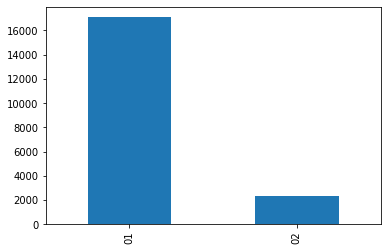

In [19]:
print(train['Coicop2_Final'].value_counts())
train['Coicop2_Final'].value_counts().plot(kind='bar')

In [15]:
(2303 / (17099 + 2303)) * 100

11.869910318523862

In [16]:
(504 / (7157 + 504)) * 100

6.578775616760215

01    17099
02     2303
Name: Coicop2_Final, dtype: int64


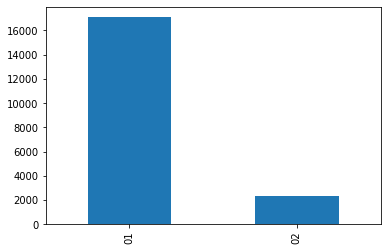

In [20]:
print(train['Coicop2_Final'].value_counts())
train['Coicop2_Final'].value_counts().plot(kind='bar')

In [21]:
train.head(1)

,product_name,product_description,source,category,Coicop2_Final,Coicop3_Final,Coicop4_Final,Coicop5_Final
0,Chio Popcorn,Süß oder Toffee Karamell 120-g-Packung,1,Popcorn Knabberartikel Lebensmittel,01,011,0111,01118


011    14710
012     2389
021     2079
022      224
Name: Coicop3_Final, dtype: int64


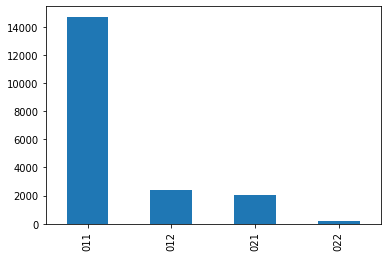

In [22]:
print(train['Coicop3_Final'].value_counts())
train['Coicop3_Final'].value_counts().plot(kind='bar')

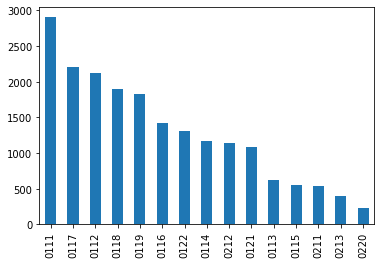

In [23]:
train['Coicop4_Final'].value_counts().plot(kind='bar')

01171    1037
02121    1021
01114     800
01191     705
01161     612
01127     579
01116     569
01212     567
02111     530
01182     474
01223     467
01184     463
01211     450
01221     444
01117     415
01173     415
01192     408
01163     406
01222     395
01199     370
01164     349
01124     348
01183     335
01185     334
01121     331
01174     307
01146     303
01118     298
01136     291
01145     281
         ... 
01123     166
01175     165
02131     163
01154     158
02133     149
01126     149
01194     140
01152      95
01131      88
01176      68
01132      68
01213      66
01153      65
02122      64
02132      60
01134      59
01133      58
01135      55
01141      54
01162      49
01155      44
01143      44
02203      41
01186      40
02124      37
01142      36
02134      29
02123      18
02202       9
02112       8
Name: Coicop5_Final, Length: 74, dtype: int64


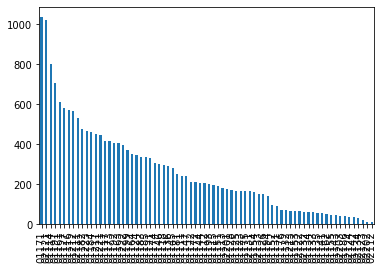

In [24]:
print(train['Coicop5_Final'].value_counts())
train['Coicop5_Final'].value_counts().plot(kind='bar')

In [25]:
train.shape

(19402, 8)

In [26]:
target = 'Coicop2_Final'
max_words = 30
max_words_pname = 6
max_chars = 250

In [27]:
def generate_label_map(df, col_):
    label2idx = {}; idx2label = {}
    count = 0
    for i in df[col_].unique():
        label2idx[i] = count
        idx2label[count] = i
        count= count + 1
    return label2idx, idx2label
    
def get_label_onehot(labels, label2idx):
    new_labels = []
    for label in labels:
        idx = label2idx[label]
        new_label = []
        for i in range(len(label2idx)):
            if i == idx:
                new_label.append(1)
            else:
                new_label.append(0)
        new_labels.append(new_label)
    return new_labels

def inverse_transform(predictions, idx2label):
    orig_labels = []
    for i in predictions:
        orig_labels.append(idx2label[i])
    return orig_labels

In [28]:
# orig code that works
num = 10000

#product_desc = c1['product_description'].values.tolist() + c2['product_description'].values.tolist()
#product_name = c1['product_name'].values.tolist() + c2['product_name'].values.tolist()
#labels = c1[target].values.tolist() + [i for i in np.zeros(1544)] #c2[target].values.tolist()

#products = train_ws['product_name']
product_desc = train['product_description']
product_name = train['product_name']

one_hot_labels = pd.get_dummies(train[target])
label2idx, idx2label = generate_label_map(train, target) #TODO : save with the model
one_hot_labels = get_label_onehot(train[target], label2idx)

product_desc = [str(i) for i in product_desc]
product_name = [str(i) for i in product_name]

wordt = Tokenizer(lower=True)
chart = Tokenizer(char_level = True, lower=True)

wordt.fit_on_texts(product_name + product_desc)
chart.fit_on_texts(product_name + product_desc)

# print(wordt.word_counts)
product_name_seq = wordt.texts_to_sequences(product_name)
product_name_seq = pad_sequences(product_name_seq, maxlen= max_words_pname, padding='post', truncating = 'post')
product_desc_seq = wordt.texts_to_sequences(product_desc)
product_desc_seq = pad_sequences(product_desc_seq, maxlen= max_words, padding='post', truncating = 'post')

char_desc_seq = chart.texts_to_sequences(product_desc)
char_desc_seq = pad_sequences(char_desc_seq, maxlen= max_chars, padding='post', truncating = 'post')
char_name_seq = chart.texts_to_sequences(product_name)
char_name_seq = pad_sequences(char_name_seq, maxlen= max_chars, padding='post', truncating = 'post')

In [29]:
label2idx, idx2label = generate_label_map(train, target) #TODO : save with the model
one_hot_labels = get_label_onehot(train[target], label2idx)

In [30]:
word_index = wordt.word_index
max_features = 25000
num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 300

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))
num_unknown = 0
# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = glov.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)
        num_unknown = num_unknown + 1
print(num_unknown)

23359


NameError: name 'glov' is not defined

In [48]:
#model 5
SEED = 12545

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)

words_input = Input(shape=(max_words_pname, ), dtype='float32')
word_embed_1 = Embedding(num_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_words_pname, trainable=True) (words_input)
words_flatten_1 = Flatten()(word_embed_1)
words_dropout_1 = Dropout(rate = 0.3)(words_flatten_1)

words_1 = Dense(24, activation='tanh')(words_dropout_1)

words_input2 = Input(shape=(max_words, ), dtype='float32')
words_2 = Dense(24, activation='tanh')(words_input2)

chars_input = Input(shape=(max_chars, ), dtype='float32')

embed_char_out= Embedding(len(chart.word_counts), 10, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5), name='char_embedding')(chars_input) #, activity_regularizer=regularizers.l2(0.01)) #TODO : regulazier affects accuracz quite a bit 
char_1 = Flatten()(embed_char_out)
char_2 = Dense(32, activation='tanh')(char_1)

t1 = concatenate ([words_1, words_2, char_2])
t2 = Dropout(rate = 0.3)(t1)

dense_2 = Dense(24, activation='tanh')(t2)
dense_3 = Dense(10, activation='tanh')(dense_2)
op = Dense(len(label2idx), activation='softmax')(dense_3)
model = Model(inputs=[words_input, words_input2, chars_input], outputs=op)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], )
history = model.fit([product_name_seq, product_desc_seq, char_name_seq], np.asarray(one_hot_labels), epochs=13, validation_split = 0.2, verbose = 1, callbacks=[es]) #, class_weight=class_weight)  # starts training

Train on 15521 samples, validate on 3881 samples
Epoch 1/13
15521/15521 [==============================] - 5s 350us/step - loss: 2.1035 - acc: 0.3446 - val_loss: 1.5298 - val_acc: 0.5676
Epoch 2/13
15521/15521 [==============================] - 4s 264us/step - loss: 1.3129 - acc: 0.6308 - val_loss: 1.0407 - val_acc: 0.7279
Epoch 3/13
15521/15521 [==============================] - 4s 265us/step - loss: 0.8685 - acc: 0.7723 - val_loss: 0.7906 - val_acc: 0.7998
Epoch 4/13
15521/15521 [==============================] - 4s 263us/step - loss: 0.6205 - acc: 0.8434 - val_loss: 0.6734 - val_acc: 0.8287
Epoch 5/13
15521/15521 [==============================] - 4s 265us/step - loss: 0.4638 - acc: 0.8792 - val_loss: 0.6085 - val_acc: 0.8464
Epoch 6/13
15521/15521 [==============================] - 4s 264us/step - loss: 0.3687 - acc: 0.9045 - val_loss: 0.5634 - val_acc: 0.8591
Epoch 7/13
15521/15521 [==============================] - 4s 266us/step - loss: 0.2988 - acc: 0.9196 - val_loss: 0.5342 - v

In [75]:
#2 and 3 
SEED = 12545

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)

words_input = Input(shape=(max_words_pname, ), dtype='float32')
word_embed_1 = Embedding(num_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_words_pname, trainable=False) (words_input)
words_flatten_1 = Flatten()(word_embed_1)
words_dropout_1 = Dropout(rate = 0.3)(words_flatten_1)

words_1 = Dense(32, activation='tanh')(words_dropout_1)

words_input2 = Input(shape=(max_words, ), dtype='float32')
words_2 = Dense(32, activation='tanh')(words_input2)

chars_input = Input(shape=(max_chars, ), dtype='float32')

embed_char_out= Embedding(len(chart.word_counts), 10, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5), name='char_embedding')(chars_input) #, activity_regularizer=regularizers.l2(0.01)) #TODO : regulazier affects accuracz quite a bit 
char_1 = Flatten()(embed_char_out)
char_2 = Dense(64, activation='tanh')(char_1)

t1 = concatenate ([words_1, words_2, char_2])
t2 = Dropout(rate = 0.25)(t1)

dense_2 = Dense(24, activation='tanh')(t2)
dense_3 = Dense(10, activation='tanh')(dense_2)
op = Dense(len(label2idx), activation='softmax')(dense_3)
model = Model(inputs=[words_input, words_input2, chars_input], outputs=op)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], )
history = model.fit([product_name_seq, product_desc_seq, char_name_seq], np.asarray(one_hot_labels), epochs=12, validation_split = 0.2, verbose = 1, callbacks=[es]) #, class_weight=class_weight)  # starts training

Train on 15521 samples, validate on 3881 samples
Epoch 1/12
15521/15521 [==============================] - 5s 299us/step - loss: 0.1989 - acc: 0.9266 - val_loss: 0.1285 - val_acc: 0.9572
Epoch 2/12
15521/15521 [==============================] - 3s 201us/step - loss: 0.1332 - acc: 0.9519 - val_loss: 0.1093 - val_acc: 0.9624
Epoch 3/12
15521/15521 [==============================] - 3s 201us/step - loss: 0.1084 - acc: 0.9612 - val_loss: 0.0996 - val_acc: 0.9670
Epoch 4/12
15521/15521 [==============================] - 3s 201us/step - loss: 0.0853 - acc: 0.9691 - val_loss: 0.1104 - val_acc: 0.9598
Epoch 5/12
15521/15521 [==============================] - 3s 201us/step - loss: 0.0721 - acc: 0.9757 - val_loss: 0.0964 - val_acc: 0.9686
Epoch 6/12
15521/15521 [==============================] - 3s 202us/step - loss: 0.0650 - acc: 0.9777 - val_loss: 0.0969 - val_acc: 0.9699
Epoch 7/12
15521/15521 [==============================] - 3s 200us/step - loss: 0.0559 - acc: 0.9798 - val_loss: 0.1028 - v

In [228]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 6, 300)       7007700     input_58[0][0]                   
__________________________________________________________________________________________________
input_60 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
flatten_39 (Flatten)            (None, 1800)         0           embedding_20[0][0]               
___________________________________________________________________________________________

In [76]:
eval_col_map = {'Coicop5_Final' :'Predicted_COICOP_5_Category', 'Coicop4_Final' : 'Predicted_COICOP_4_Category', 'Coicop3_Final' : 'Predicted_COICOP_3_Category', 'Coicop2_Final' : 'Predicted_COICOP_2_Category'}

In [44]:
#file_name = './models/model_metadata_' + target + '.pkl'
#with open(file_name, "wb") as f:
#    pickle.dump(label2idx, f)
#    pickle.dump(idx2label, f)
#    pickle.dump(chart, f)
#    pickle.dump(wordt, f)
#    pickle.dump(embedding_matrix, f)
#    pickle.dump(eval_col_map, f)
#    pickle.dump(history, f)
#    
#model.save('./models/model' + target + '.h5')

In [77]:
op = model.predict([product_name_seq, product_desc_seq, char_name_seq])

In [24]:
#['01118', '01172', '01117', '01213', '01114', '01136', '01121', '01161', '01125', '01185', '01127', '02133', '01122', '01116', '01124', '01175', '01132', '01221', '01222', '01192', '01128', '01171', '01191', '01184', '01164', '01151', '01181', '01163', '01112', '01115', '01173', '01113', '01211', '02121', '01145', '01223', '01147', '01183', '01154', '02111', '02131', '02122', '01182', '01126', '01174', '01162', '01146', '01176', '01111', '01123', '01133', '01134', '01152', '01199', '01193', '02132', '01212', '01131', '01135', '01153', '01155', '01194', '02134', '01186', '02124', '01144', '02201', '01142', '01143', '02202', '02203', '01141', '02123', '02112']
#['0111', '0117', '0121', '0113', '0112', '0116', '0118', '0213', '0122', '0119', '0115', '0212', '0114', '0211', '0220']
#['011', '012', '021', '022']
#['01', '02']
#lst

In [78]:
prediction = []
for i in op:
    prediction.append(i.tolist().index(max(i)))

preds2 = inverse_transform(prediction, idx2label)
train[eval_col_map[target]] = preds2

In [80]:
# orig code that works
num = 10000
#test
#product_desc = c1['product_description'].values.tolist() + c2['product_description'].values.tolist()
#product_name = c1['product_name'].values.tolist() + c2['product_name'].values.tolist()
#labels = c1[target].values.tolist() + [i for i in np.zeros(1544)] #c2[target].values.tolist()

#products = train_ws['product_name']
df = test_ws #test_ws test_mg

product_desct = df['product_description']
product_namet = df['product_name']

product_desct = [str(i) for i in product_desct]
product_namet = [str(i) for i in product_namet]

# print(wordt.word_counts)
product_name_seqt = wordt.texts_to_sequences(product_namet)
product_name_seqt = pad_sequences(product_name_seqt, maxlen= max_words_pname, padding='post', truncating = 'post')
product_desc_seqt = wordt.texts_to_sequences(product_desct)
product_desc_seqt = pad_sequences(product_desc_seqt, maxlen= max_words, padding='post', truncating = 'post')

char_desc_seqt = chart.texts_to_sequences(product_desct)
char_desc_seqt = pad_sequences(char_desc_seqt, maxlen= max_chars, padding='post', truncating = 'post')
char_name_seqt = chart.texts_to_sequences(product_namet)
char_name_seqt = pad_sequences(char_name_seqt, maxlen= max_chars, padding='post', truncating = 'post')
opt = model.predict([product_name_seqt, product_desc_seqt, char_name_seqt])
predictiont = []
for i in opt:
    predictiont.append(i.tolist().index(max(i)))

preds2t = inverse_transform(predictiont, idx2label)
df[eval_col_map[target]] = preds2t

In [81]:
test_mg[eval_col_map[target]]

0      01
1      01
2      01
3      01
4      01
       ..
953    01
954    01
955    01
956    01
957    02
Name: Predicted_COICOP_2_Category, Length: 958, dtype: object

In [82]:
test_ws[eval_col_map[target]]

0       01
1       02
2       01
3       01
4       01
        ..
1193    02
1194    01
1195    01
1196    01
1197    01
Name: Predicted_COICOP_2_Category, Length: 1198, dtype: object

In [85]:
test_mg['Predicted_COICOP_5_Category']

0      01128
1      01164
2      01154
3      01124
4      01184
       ...  
953    01127
954    01161
955    01171
956    01172
957    02131
Name: Predicted_COICOP_5_Category, Length: 958, dtype: object

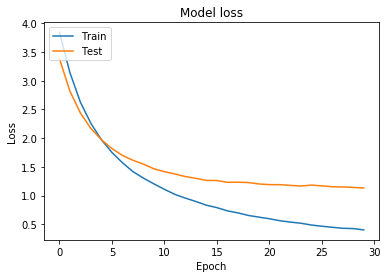

In [242]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

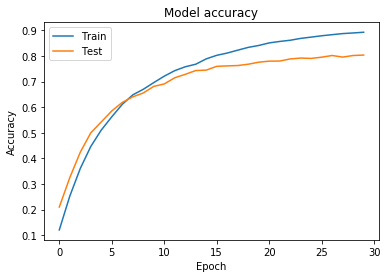

In [243]:
# Plotsummaryining & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()